# Experiment 3: Gaussian Process Regression (4D)

This notebook evaluates the effectiveness of different point sets for Gaussian Process Regression in 4 dimensions.

**Test Functions:**
1. **Corner Peak** - Sharp feature at corner
2. **Product Peak** - Multiple local features
3. **Sum of Gaussians** - Multiple Gaussian bumps

**Comparison:** Korobov, Explicit rank-1, Random, Halton, Sobol point sets

## Setup

In [ ]:
# Uncomment for Google Colab
# !pip install numpy scipy matplotlib qmcpy scikit-learn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from functools import reduce
from typing import List, Tuple, Optional, Callable
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice
from lattice_qmc.utils import generate_primes, compute_separation_radius_fast

# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available.")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions for Point Sets

In [4]:
# ============================================================
# Other Point Set Generators
# ============================================================

def generate_random_points(n: int, d: int, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
    return np.random.rand(n, d)

def generate_halton_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)

def generate_sobol_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)

print("Point set generators loaded.")

Point set generators loaded.


---

## Part 1: 4D Test Functions

### 1.1 Corner Peak Function

A function with a sharp peak at the corner, commonly used in integration testing:

$$
f(x) = \left(1 + \sum_{i=1}^{4} c_i x_i \right)^{-(d+1)}
$$

where $c_i$ controls the sharpness.

In [5]:
def corner_peak_4d(X: np.ndarray) -> np.ndarray:
    """
    Corner Peak test function for 4D.
    
    f(x) = (1 + sum(c_i * x_i))^(-(d+1))
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 4) in [0, 1]^4.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    d = 4
    c = np.array([1.0, 2.0, 3.0, 4.0])  # Coefficients
    
    inner = 1.0 + np.sum(c * X, axis=1)
    return inner ** (-(d + 1))


# Test
test_pts = np.array([[0.5]*4, [0.0]*4, [1.0]*4])
print("Corner Peak function values:")
print(corner_peak_4d(test_pts))

Corner Peak function values:
[1.28600823e-04 1.00000000e+00 6.20921323e-06]


### 1.2 Product Peak Function

A function with product structure:

$$
f(x) = \prod_{i=1}^{4} \left( c_i^{-2} + (x_i - u_i)^2 \right)^{-1}
$$

where $u_i$ are peak locations and $c_i$ control peak widths.

In [6]:
def product_peak_4d(X: np.ndarray) -> np.ndarray:
    """
    Product Peak test function for 4D.
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 4) in [0, 1]^4.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    # Peak locations and widths
    u = np.array([0.5, 0.5, 0.5, 0.5])
    c = np.array([0.2, 0.2, 0.2, 0.2])
    
    result = np.ones(X.shape[0])
    for i in range(4):
        result *= 1.0 / (c[i]**(-2) + (X[:, i] - u[i])**2)
    
    # Normalize to reasonable range
    return result / 1e6


print("Product Peak function values:")
print(product_peak_4d(test_pts))

Product Peak function values:
[2.56000000e-12 2.46010968e-12 2.46010968e-12]


### 1.3 Sum of Gaussians Function

A function with multiple localized features:

$$
f(x) = \sum_{i=1}^{4} a_i \exp\left( -\frac{\|x - c_i\|^2}{2\sigma_i^2} \right)
$$

where $c_i$ are centers, $\sigma_i$ are widths, and $a_i$ are amplitudes.

In [7]:
def sum_of_gaussians_4d(X: np.ndarray) -> np.ndarray:
    """
    Sum of Gaussians test function for 4D.
    
    Multiple Gaussian bumps at different locations.
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 4) in [0, 1]^4.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    # Define Gaussian centers and widths
    centers = np.array([
        [0.2, 0.2, 0.2, 0.2],
        [0.8, 0.8, 0.8, 0.8],
        [0.5, 0.5, 0.5, 0.5],
        [0.3, 0.7, 0.3, 0.7],
    ])
    sigmas = np.array([0.15, 0.15, 0.2, 0.12])
    amplitudes = np.array([1.0, 1.0, 0.8, 0.6])
    
    result = np.zeros(X.shape[0])
    for c, sigma, amp in zip(centers, sigmas, amplitudes):
        dist_sq = np.sum((X - c)**2, axis=1)
        result += amp * np.exp(-dist_sq / (2 * sigma**2))
    
    return result


print("Sum of Gaussians values:")
print(sum_of_gaussians_4d(test_pts))

Sum of Gaussians values:
[0.80299048 0.02856848 0.02856848]


---

## Part 2: GPR Implementation for 4D

In [8]:
def fit_gpr(X_train: np.ndarray, y_train: np.ndarray, 
            length_scale: float = 0.3, alpha: float = 1e-6) -> GaussianProcessRegressor:
    """
    Fit a Gaussian Process Regressor.
    """
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=length_scale, 
                                           length_scale_bounds=(1e-2, 1e1),
                                           nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, 
                                   n_restarts_optimizer=3,
                                   normalize_y=True)
    gpr.fit(X_train, y_train)
    return gpr


def compute_l2_error_mc(gpr: GaussianProcessRegressor, 
                        true_func: Callable,
                        d: int,
                        n_mc: int = 10000,
                        seed: int = 12345) -> float:
    """
    Compute L² error using Monte Carlo integration.
    
    For high dimensions, MC is more practical than tensor product quadrature.
    
    ||f - f_GPR||_{L²}² ≈ (1/n) Σ |f(x_i) - f_GPR(x_i)|²
    
    Parameters
    ----------
    gpr : GaussianProcessRegressor
        Fitted GPR model.
    true_func : Callable
        True function.
    d : int
        Dimension.
    n_mc : int
        Number of Monte Carlo samples.
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    float
        Estimated L² error.
    """
    # Use pure Monte Carlo (random points)
    np.random.seed(seed)
    X_mc = np.random.rand(n_mc, d)
    
    # Evaluate
    f_true = true_func(X_mc)
    f_gpr = gpr.predict(X_mc)
    
    # L² error (MC estimate)
    l2_error_sq = np.mean((f_true - f_gpr)**2)
    return np.sqrt(l2_error_sq)


# Configuration for noisy observations
NOISE_STD = 0.05  # Standard deviation of observation noise
N_TRIALS = 100    # Number of Monte Carlo trials

print("GPR functions for 4D loaded.")
print(f"Noise std: {NOISE_STD}, Number of trials: {N_TRIALS}")

GPR functions for 4D loaded.
Noise std: 0.05, Number of trials: 100


---

## Part 3: Run Experiments

### 3.1 Configuration

In [13]:
d = 4

# Point counts for each method
korobov_primes_4d = [17, 31, 67, 127, 257, 509]
explicit_m_values_4d = list(range(6, 12))
sobol_powers_4d = [16, 32, 64, 128, 256, 512]
halton_random_n_4d = [16, 32, 64, 128, 256, 512]

print(f"Configuration for d = {d}:")
print(f"  Korobov primes: {korobov_primes_4d}")
print(f"  Explicit m values: {explicit_m_values_4d}")
print(f"  Sobol powers: {sobol_powers_4d}")

Configuration for d = 4:
  Korobov primes: [17, 31, 67, 127, 257, 509]
  Explicit m values: [6, 7, 8, 9, 10, 11]
  Sobol powers: [16, 32, 64, 128, 256, 512]


### 3.2 Run Experiment Function

In [14]:
def run_gpr_experiment_4d(test_func: Callable, func_name: str, n_trials: int = N_TRIALS):
    """
    Run GPR experiment for all point set types in 4D with noisy observations.
    Each configuration is run n_trials times with different noise realizations.
    """
    results = {
        'korobov': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'explicit': {'N': [], 'l2_error_mean': [], 'l2_error_std': [], 'm': []},
        'random': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'halton': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'sobol': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
    }
    
    d = 4
    print(f"\n{'='*60}")
    print(f"GPR Experiment: {func_name} (d = {d})")
    print(f"Noise std: {NOISE_STD}, Trials: {n_trials}")
    print(f"{'='*60}")
    
    # Korobov lattices
    print("\nKorobov lattices:")
    for N in korobov_primes_4d:
        print(f"  N = {N}: ", end="", flush=True)
        lattice = KorobovLattice(d=d, N=N)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['korobov']['N'].append(N)
        results['korobov']['l2_error_mean'].append(np.mean(errors))
        results['korobov']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Explicit rank-1 lattices
    print("\nExplicit rank-1 lattices:")
    for m in explicit_m_values_4d:
        print(f"  m = {m}: ", end="", flush=True)
        lattice = ExplicitRank1Lattice(d=d, m=m)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['explicit']['N'].append(lattice.Q)
        results['explicit']['l2_error_mean'].append(np.mean(errors))
        results['explicit']['l2_error_std'].append(np.std(errors))
        results['explicit']['m'].append(m)
        print(f"Q = {lattice.Q}, L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Random points
    print("\nRandom points:")
    for n in halton_random_n_4d:
        print(f"  N = {n}: ", end="", flush=True)
        errors = []
        for trial in range(n_trials):
            np.random.seed(42 + trial)
            X_train = np.random.rand(n, d)
            y_true = test_func(X_train)
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['random']['N'].append(n)
        results['random']['l2_error_mean'].append(np.mean(errors))
        results['random']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Halton
    if QMCPY_AVAILABLE:
        print("\nHalton sequence:")
        for n in halton_random_n_4d:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_halton_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['halton']['N'].append(n)
            results['halton']['l2_error_mean'].append(np.mean(errors))
            results['halton']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
        
        # Sobol
        print("\nSobol sequence:")
        for n in sobol_powers_4d:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_sobol_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['sobol']['N'].append(n)
            results['sobol']['l2_error_mean'].append(np.mean(errors))
            results['sobol']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    return results

### 3.3 Run Experiments for Each Test Function

In [15]:
# Experiment 1: Corner Peak function
results_corner = run_gpr_experiment_4d(corner_peak_4d, "Corner Peak")


GPR Experiment: Corner Peak (d = 4)
Noise std: 0.05, Trials: 100

Korobov lattices:
  N = 17: L² = 8.025310e-02 ± 1.329120e-02
  N = 31: L² = 8.025310e-02 ± 1.329120e-02
  N = 31: L² = 8.949539e-02 ± 6.755386e-03
  N = 67: L² = 8.949539e-02 ± 6.755386e-03
  N = 67: L² = 6.151408e-02 ± 4.480249e-03
  N = 127: L² = 6.151408e-02 ± 4.480249e-03
  N = 127: L² = 2.985758e-02 ± 1.523639e-02
  N = 257: L² = 2.985758e-02 ± 1.523639e-02
  N = 257: L² = 2.853476e-02 ± 1.136577e-02
  N = 509: L² = 2.853476e-02 ± 1.136577e-02
  N = 509: L² = 1.936442e-02 ± 1.400125e-02

Explicit rank-1 lattices:
  m = 6: L² = 1.936442e-02 ± 1.400125e-02

Explicit rank-1 lattices:
  m = 6: Q = 12, L² = 7.843484e-02 ± 1.551982e-02
  m = 7: Q = 12, L² = 7.843484e-02 ± 1.551982e-02
  m = 7: Q = 19, L² = 1.072429e-01 ± 7.036966e-03
  m = 8: Q = 19, L² = 1.072429e-01 ± 7.036966e-03
  m = 8: Q = 66, L² = 7.499932e-02 ± 6.464187e-03
  m = 9: Q = 66, L² = 7.499932e-02 ± 6.464187e-03
  m = 9: Q = 128, L² = 6.048257e-02 ± 5.

In [16]:
# Experiment 2: Product Peak function
results_product = run_gpr_experiment_4d(product_peak_4d, "Product Peak")


GPR Experiment: Product Peak (d = 4)
Noise std: 0.05, Trials: 100

Korobov lattices:
  N = 17: L² = 1.519313e-02 ± 1.107341e-02
  N = 31: L² = 1.519313e-02 ± 1.107341e-02
  N = 31: L² = 1.295703e-02 ± 9.233497e-03
  N = 67: L² = 1.295703e-02 ± 9.233497e-03
  N = 67: L² = 1.025992e-02 ± 7.320272e-03
  N = 127: L² = 1.025992e-02 ± 7.320272e-03
  N = 127: L² = 8.743316e-03 ± 7.117538e-03
  N = 257: L² = 8.743316e-03 ± 7.117538e-03
  N = 257: L² = 8.154331e-03 ± 6.828514e-03
  N = 509: L² = 8.154331e-03 ± 6.828514e-03
  N = 509: L² = 7.416820e-03 ± 6.495672e-03

Explicit rank-1 lattices:
  m = 6: L² = 7.416820e-03 ± 6.495672e-03

Explicit rank-1 lattices:
  m = 6: Q = 12, L² = 1.462339e-02 ± 1.063270e-02
  m = 7: Q = 12, L² = 1.462339e-02 ± 1.063270e-02
  m = 7: Q = 19, L² = 1.448412e-02 ± 9.773162e-03
  m = 8: Q = 19, L² = 1.448412e-02 ± 9.773162e-03
  m = 8: Q = 66, L² = 9.474410e-03 ± 6.614021e-03
  m = 9: Q = 66, L² = 9.474410e-03 ± 6.614021e-03
  m = 9: Q = 128, L² = 7.568402e-03 ± 6

In [17]:
# Experiment 3: Sum of Gaussians
results_gaussians = run_gpr_experiment_4d(sum_of_gaussians_4d, "Sum of Gaussians")


GPR Experiment: Sum of Gaussians (d = 4)
Noise std: 0.05, Trials: 100

Korobov lattices:
  N = 17: L² = 1.251186e-01 ± 1.806920e-03
  N = 31: L² = 1.251186e-01 ± 1.806920e-03
  N = 31: L² = 1.050309e-01 ± 4.698808e-03
  N = 67: L² = 1.050309e-01 ± 4.698808e-03
  N = 67: L² = 7.538956e-02 ± 5.402545e-03
  N = 127: L² = 7.538956e-02 ± 5.402545e-03
  N = 127: L² = 5.807963e-02 ± 2.202886e-03
  N = 257: L² = 5.807963e-02 ± 2.202886e-03
  N = 257: L² = 4.897797e-02 ± 1.586818e-03
  N = 509: L² = 4.897797e-02 ± 1.586818e-03
  N = 509: L² = 4.214419e-02 ± 1.479633e-03

Explicit rank-1 lattices:
  m = 6: L² = 4.214419e-02 ± 1.479633e-03

Explicit rank-1 lattices:
  m = 6: Q = 12, L² = 1.275743e-01 ± 4.896942e-03
  m = 7: Q = 12, L² = 1.275743e-01 ± 4.896942e-03
  m = 7: Q = 19, L² = 1.256551e-01 ± 4.671730e-03
  m = 8: Q = 19, L² = 1.256551e-01 ± 4.671730e-03
  m = 8: Q = 66, L² = 9.321477e-02 ± 2.619828e-03
  m = 9: Q = 66, L² = 9.321477e-02 ± 2.619828e-03
  m = 9: Q = 128, L² = 8.433469e-02

---

## Part 4: Visualization

In [18]:
def plot_gpr_results(results: dict, d: int, func_name: str, save_fig: bool = True):
    """
    Plot L² error vs number of points with error bars.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std, 
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=10,
                       capsize=3, capthick=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    ax.set_title(f'GPR Approximation Error ({func_name}, $d = {d}$)\nNoise $\\sigma = {NOISE_STD}$, {N_TRIALS} trials')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_fig:
        filename = f'gpr_error_{func_name.lower().replace(" ", "_")}_{d}d'
        plt.savefig(f'{filename}.pdf')
        plt.savefig(f'{filename}.png', dpi=300)
        print(f"Saved: {filename}.pdf, {filename}.png")
    
    plt.show()

Saved: gpr_error_corner_peak_4d.pdf, gpr_error_corner_peak_4d.png


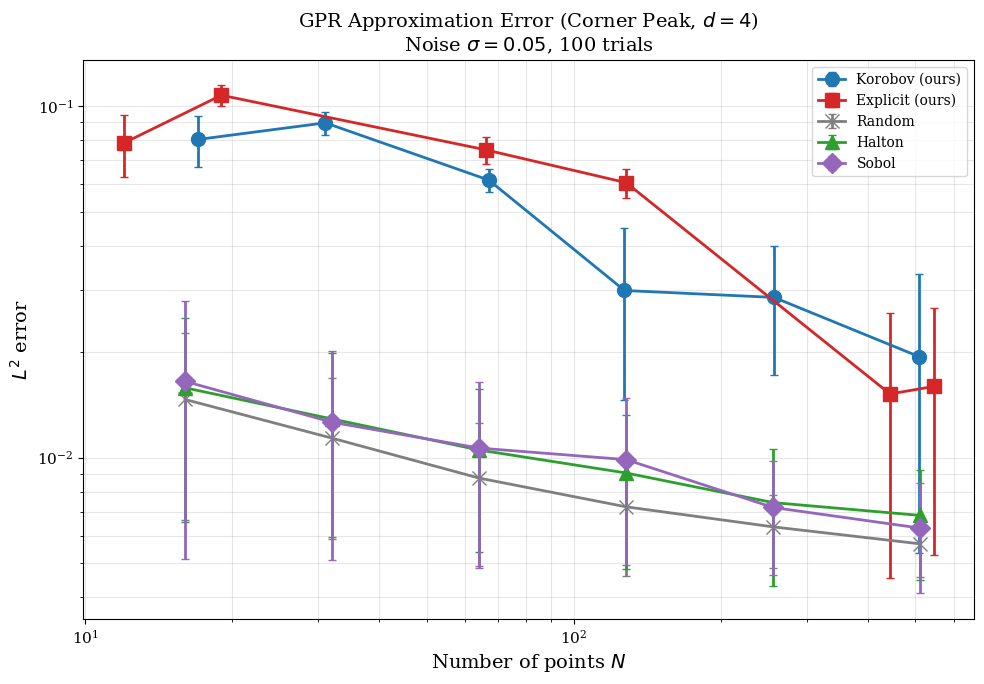

In [19]:
# Plot Corner Peak results
plot_gpr_results(results_corner, d=4, func_name="Corner Peak")

Saved: gpr_error_product_peak_4d.pdf, gpr_error_product_peak_4d.png


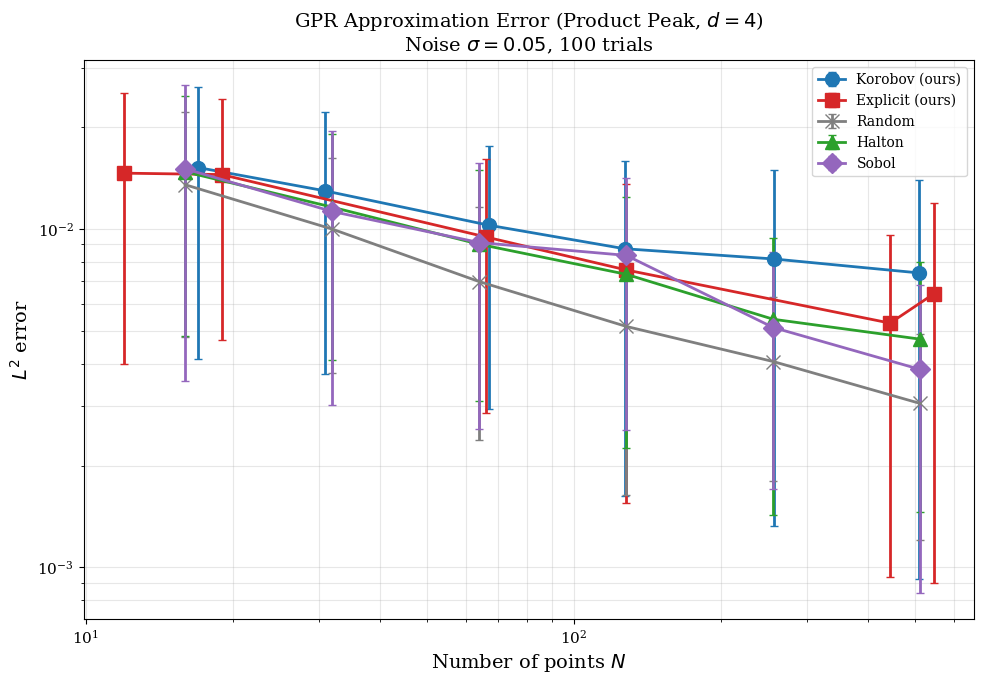

In [20]:
# Plot Product Peak results
plot_gpr_results(results_product, d=4, func_name="Product Peak")

Saved: gpr_error_sum_of_gaussians_4d.pdf, gpr_error_sum_of_gaussians_4d.png


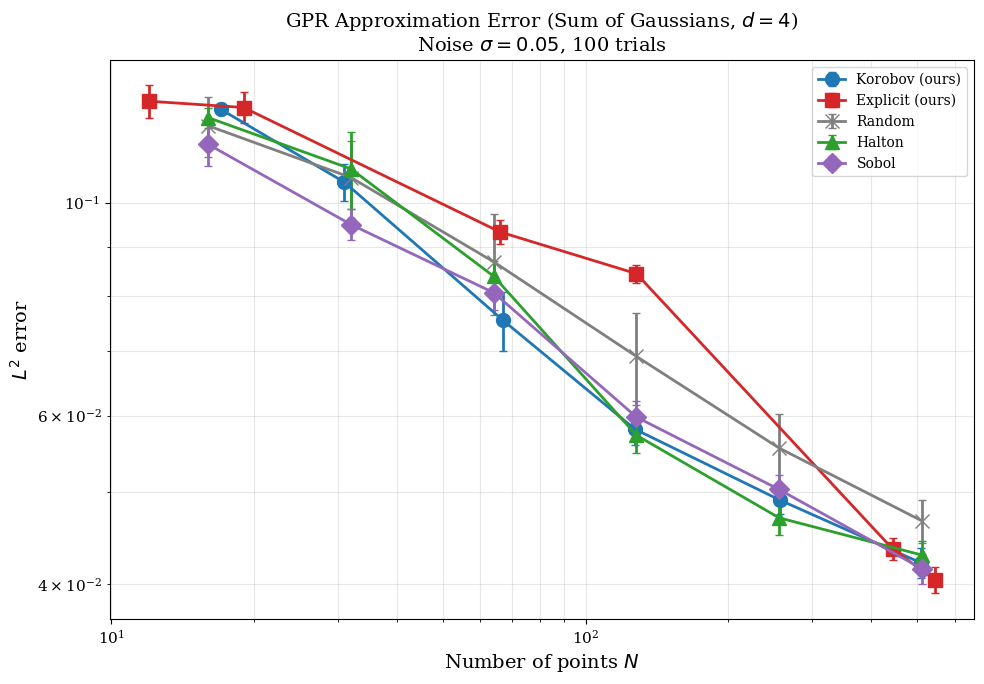

In [21]:
# Plot Sum of Gaussians results
plot_gpr_results(results_gaussians, d=4, func_name="Sum of Gaussians")

### 4.1 Combined Plot for All Test Functions

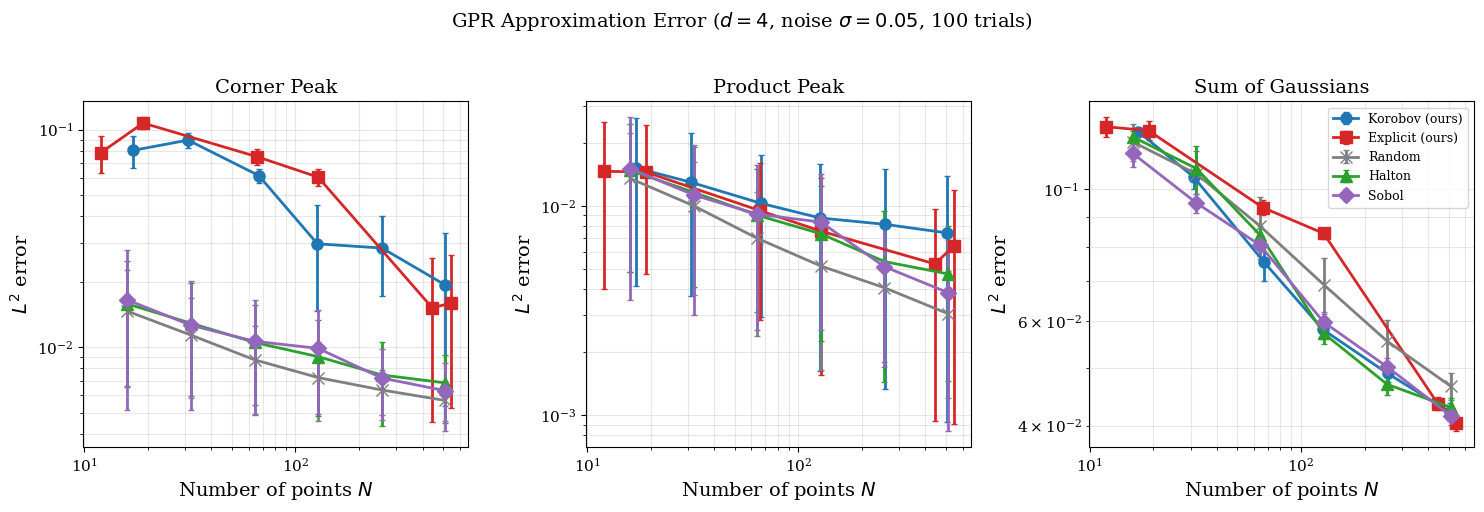


Saved: gpr_error_4d_combined.pdf, gpr_error_4d_combined.png


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

all_results = [
    (results_corner, "Corner Peak"),
    (results_product, "Product Peak"),
    (results_gaussians, "Sum of Gaussians"),
]

styles = {
    'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
    'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
    'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
    'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
    'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
}

for idx, (results, func_name) in enumerate(all_results):
    ax = axes[idx]
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std,
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=8,
                       capsize=2, capthick=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    ax.set_title(f'{func_name}')
    ax.grid(True, alpha=0.3, which='both')
    if idx == 2:
        ax.legend(loc='upper right', fontsize=9)

plt.suptitle(f'GPR Approximation Error ($d = 4$, noise $\\sigma = {NOISE_STD}$, {N_TRIALS} trials)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('gpr_error_4d_combined.pdf')
plt.savefig('gpr_error_4d_combined.png', dpi=300)
plt.show()
print("\nSaved: gpr_error_4d_combined.pdf, gpr_error_4d_combined.png")